In [262]:
# Make sure that you have the dependency installed on your system
# If not installed, install by running the following
# !pip install kafka-python

# Problem 1

In [92]:
from sklearn.metrics import classification_report
# load the saved models
import pickle
filename = 'BC_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))
adaptive_model = pickle.load(open(filename, 'rb'))

In [93]:
import numpy as np
import pandas as pd
# read static data
static_data = pd.read_csv('cicids_static_data.csv')
static_data.rename(columns=lambda x: x.strip(), inplace=True)
cols = static_data.columns
static_data = static_data.replace([np.inf, -np.inf, np.nan] , 0)
received_record_conc = pd.DataFrame(columns=cols) # DataFrame to concatenate old and new data
received_record_conc_1000 = pd.DataFrame(columns=cols) # DataFrame to concatenate a chunk of 1000 record
received_record_conc = received_record_conc.append(static_data) # Initially it contains only static data

from sklearn.metrics import f1_score
f1_1000Chunk_list_adaptive = []  # List to store adaptive model F1 scores
f1_1000Chunk_list_static = [] # List to store static model F1 scores
y_distribution_1000Chunk = [] # List to store streaming data distribution
classification_report_1000Chunk_static = [] # List to store static model classification reports
classification_report_1000Chunk_adaptive = [] # List to store adaptive model classification reports

In [94]:
received_record_conc.shape

(25191, 79)

In [95]:
import time
import ast
# Import the python Consumer Client for Kafka
from kafka import KafkaConsumer
# instantiate the KafkaConsumer Class using the arguments mentioned.
# do not change any arguments other than the first positional argument.
consumer = KafkaConsumer(
    'task1',   # change this to "task2" for the IOT Botnet Detection  ---- important ----
    bootstrap_servers="34.130.121.39:9092",
    sasl_plain_username="student",
    sasl_plain_password="uottawa",
    security_protocol="SASL_PLAINTEXT",
    sasl_mechanism="PLAIN",
    auto_offset_reset='earliest',
    enable_auto_commit=False
)

# Data Stream flowing in.
i = 0
for message in consumer:
    # print(f"Consuming the {i+1}th data packet!")
    
    data_packet = message.value

    ##############################################

    
    # your adaptation logic here #
    try:
        # try because sometimes the packet fails
        received_record_dict = ast.literal_eval(data_packet.decode('UTF-8'))
    except:
        continue
    # convert data packet to data frame, and append to the chunk's list
    received_record_df = pd.DataFrame(received_record_dict, index=[0], columns = cols)
    received_record_conc_1000 = received_record_conc_1000.append(received_record_df, ignore_index = True)
    
    # when window size is reached
    if received_record_conc_1000.shape[0] == 1000:
        # get predictions of window size
        adaptive_predictions = adaptive_model.predict(received_record_conc_1000.drop(['Label'], axis=1))
        static_predictions = loaded_model.predict(received_record_conc_1000.drop(['Label'], axis=1))
        # store scores
        f1_1000Chunk_list_adaptive.append(f1_score(received_record_conc_1000.Label, adaptive_predictions, pos_label='BENIGN'))
        f1_1000Chunk_list_static.append(f1_score(received_record_conc_1000.Label, static_predictions, pos_label='BENIGN'))
        # clean to store
        received_record_conc_1000 = received_record_conc_1000.replace([np.inf, -np.inf, np.nan] , 0)
        
        # store data distribution and classification reports
        y_distribution_1000Chunk.append(received_record_conc_1000['Label'].value_counts().values)
        classification_report_1000Chunk_static.append(classification_report(received_record_conc_1000.Label, static_predictions))
        classification_report_1000Chunk_adaptive.append(classification_report(received_record_conc_1000.Label, adaptive_predictions))
        
        # replace an old chunk with new data chunk 
        received_record_conc = received_record_conc.iloc[1000:]
#         print('received_record_conc shape after shrink: ', received_record_conc.shape)
        received_record_conc = received_record_conc.append(received_record_conc_1000, ignore_index = True)
#         print('received_record_conc shape after addition: ', received_record_conc.shape)
        received_record_conc_1000 =  pd.DataFrame(columns=cols)
        
        # re-fit the model with the new mix
        adaptive_model.fit(received_record_conc.drop(['Label'], axis=1), received_record_conc['Label'])
    
    ##############################################
    
    if i == 100000:
        break
        
    i += 1

#### Explore the results

In [96]:
len(f1_1000Chunk_list_adaptive), len(f1_1000Chunk_list_static), received_record_conc.shape

(100, 100, (25191, 79))

In [97]:
len(y_distribution_1000Chunk), len(classification_report_1000Chunk_static), len(classification_report_1000Chunk_adaptive)

(100, 100, 100)

##### Data Distribution

In [98]:
print(y_distribution_1000Chunk[4]), print(y_distribution_1000Chunk[5]), print(y_distribution_1000Chunk[6])

[890 110]
[911  89]
[906  94]


(None, None, None)

##### Accuracy Scores

In [99]:
print(classification_report_1000Chunk_static[9])


              precision    recall  f1-score   support

      ATTACK       0.98      1.00      0.99       104
      BENIGN       1.00      1.00      1.00       896

    accuracy                           1.00      1000
   macro avg       0.99      1.00      0.99      1000
weighted avg       1.00      1.00      1.00      1000



In [100]:
print(classification_report_1000Chunk_adaptive[9])

              precision    recall  f1-score   support

      ATTACK       0.99      0.99      0.99       104
      BENIGN       1.00      1.00      1.00       896

    accuracy                           1.00      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       1.00      1.00      1.00      1000



##### Plot F1-Scores

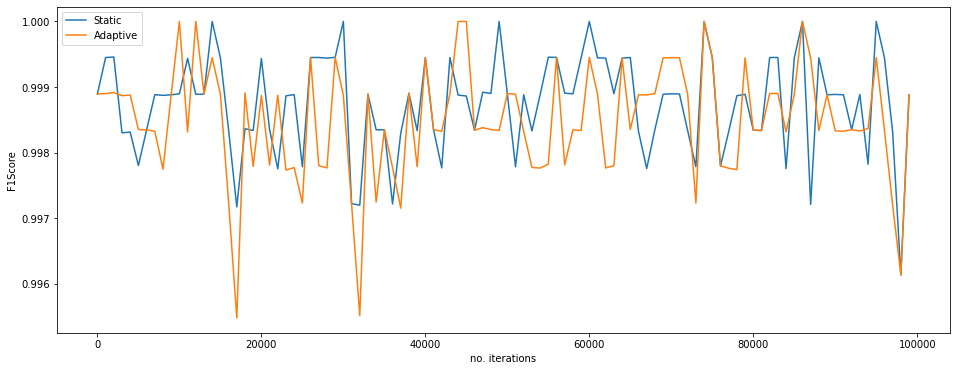

In [101]:
x_axis = np.arange(0,100000,1000)
x_axis.shape
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(16, 6))
plt.plot(x_axis, f1_1000Chunk_list_static, label='Static')
plt.plot(x_axis, f1_1000Chunk_list_adaptive, label='Adaptive')
plt.xlabel('no. iterations')
plt.ylabel('F1Score')
plt.legend()
plt.show()

##### Overall average F1-Scores

In [102]:
print("Static avg F1", sum(f1_1000Chunk_list_static)/len(f1_1000Chunk_list_static))
print("Adaptive avg F1", sum(f1_1000Chunk_list_adaptive)/len(f1_1000Chunk_list_adaptive))

Static avg F1 0.9987567985446799
Adaptive avg F1 0.9984855886385078


___________

_______________

# Problem 2

In [103]:
filename = 'MC_model.sav'
loaded_model_multi = pickle.load(open(filename, 'rb'))
adaptive_model_multi = pickle.load(open(filename, 'rb'))

In [104]:
static_data_multi = pd.read_csv('iot_static_data.csv')
static_data_multi.drop(['Source'], axis=1, inplace=True)
cols_multi = static_data_multi.columns
received_record_conc_multi = pd.DataFrame(columns=cols_multi)
received_record_conc_1000_multi = pd.DataFrame(columns=cols_multi)
received_record_conc_multi = received_record_conc_multi.append(static_data_multi)

f1_1000Chunk_list_adaptive_multi = []
f1_1000Chunk_list_static_multi = []
y_distribution_1000Chunk_multi = []
classification_report_1000Chunk_static_multi = []
classification_report_1000Chunk_adaptive_multi = []

In [105]:
received_record_conc_multi.shape

(25609, 116)

In [106]:
import time
import ast
# Import the python Consumer Client for Kafka
from kafka import KafkaConsumer
# instantiate the KafkaConsumer Class using the arguments mentioned.
# do not change any arguments other than the first positional argument.
consumer = KafkaConsumer(
    'task2',   # change this to "task2" for the IOT Botnet Detection  ---- important ----
    bootstrap_servers="34.130.121.39:9092",
    sasl_plain_username="student",
    sasl_plain_password="uottawa",
    security_protocol="SASL_PLAINTEXT",
    sasl_mechanism="PLAIN",
    auto_offset_reset='earliest',
    enable_auto_commit=False
)

# Data Stream flowing in.
i = 0
for message in consumer:
    # print(f"Consuming the {i+1}th data packet!")
    
    data_packet = message.value

    ##############################################

    
    # your adaptation logic here #
    try:
        received_record_dict = ast.literal_eval(data_packet.decode('UTF-8'))
    except:
        continue
    received_record_df = pd.DataFrame(received_record_dict, index=[0])
    received_record_df.drop(['Source'], axis=1, inplace=True)
    received_record_conc_1000_multi = received_record_conc_1000_multi.append(received_record_df, ignore_index = True)
    
    if received_record_conc_1000_multi.shape[0] == 1000:
        
        adaptive_predictions = adaptive_model_multi.predict(received_record_conc_1000_multi.drop(['Class'], axis=1))
        static_predictions = loaded_model_multi.predict(received_record_conc_1000_multi.drop(['Class'], axis=1))

        f1_1000Chunk_list_adaptive_multi.append(f1_score(received_record_conc_1000_multi.Class, adaptive_predictions, average='weighted'))
        f1_1000Chunk_list_static_multi.append(f1_score(received_record_conc_1000_multi.Class, static_predictions, average='weighted'))
        
        received_record_conc_1000_multi = received_record_conc_1000_multi.replace([np.inf, -np.inf, np.nan] , 0)
        
        
        y_distribution_1000Chunk_multi.append(received_record_conc_1000_multi['Class'].value_counts().values)
        classification_report_1000Chunk_static_multi.append(classification_report(received_record_conc_1000_multi.Class, static_predictions))
        classification_report_1000Chunk_adaptive_multi.append(classification_report(received_record_conc_1000_multi.Class, adaptive_predictions))
        
        
        received_record_conc_multi = received_record_conc_multi.iloc[1000:]
#         print('received_record_conc shape after shrink: ', received_record_conc_multi.shape)
        received_record_conc_multi = received_record_conc_multi.append(received_record_conc_1000_multi, ignore_index = True)
#         print('received_record_conc shape after addition: ', received_record_conc_multi.shape)
        received_record_conc_1000_multi =  pd.DataFrame(columns=cols_multi)
        
        
        adaptive_model_multi.fit(received_record_conc_multi.drop(['Class'], axis=1), received_record_conc_multi['Class'])
    
    ##############################################
    
    if i == 100000:
        break
        
    i += 1

/home/yomna/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yomna/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yomna/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yomna/anaconda3/lib/python3.

/home/yomna/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yomna/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yomna/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yomna/anaconda3/lib/python3.

/home/yomna/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yomna/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yomna/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yomna/anaconda3/lib/python3.8/site-packages/sklearn/

/home/yomna/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yomna/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yomna/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yomna/anaconda3/lib/python3.

/home/yomna/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yomna/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yomna/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yomna/anaconda3/lib/python3.

#### Explore the results

In [107]:
len(f1_1000Chunk_list_adaptive_multi) , len(f1_1000Chunk_list_static_multi)

(100, 100)

##### Data Distribution

In [108]:
print(y_distribution_1000Chunk_multi[50])

[857  76  18  17  11   8   8   3   2]


##### Accuracy Scores

In [109]:
print(classification_report_1000Chunk_static_multi[99])


                    precision    recall  f1-score   support

            BENIGN       1.00      1.00      1.00       854
gafgyt_junk_attack       1.00      1.00      1.00        16
gafgyt_scan_attack       1.00      1.00      1.00        14
 gafgyt_tcp_attack       1.00      0.93      0.97        15
 gafgyt_udp_attack       0.95      1.00      0.97        19
  mirai_ack_attack       1.00      1.00      1.00         7
 mirai_scan_attack       1.00      1.00      1.00         4
  mirai_syn_attack       1.00      1.00      1.00         2
  mirai_udp_attack       1.00      1.00      1.00        69

          accuracy                           1.00      1000
         macro avg       0.99      0.99      0.99      1000
      weighted avg       1.00      1.00      1.00      1000



In [110]:
print(classification_report_1000Chunk_adaptive_multi[99])

                    precision    recall  f1-score   support

            BENIGN       1.00      1.00      1.00       854
gafgyt_junk_attack       1.00      1.00      1.00        16
gafgyt_scan_attack       1.00      1.00      1.00        14
 gafgyt_tcp_attack       1.00      0.93      0.97        15
 gafgyt_udp_attack       0.95      1.00      0.97        19
  mirai_ack_attack       1.00      1.00      1.00         7
 mirai_scan_attack       1.00      1.00      1.00         4
  mirai_syn_attack       1.00      1.00      1.00         2
  mirai_udp_attack       1.00      1.00      1.00        69

          accuracy                           1.00      1000
         macro avg       0.99      0.99      0.99      1000
      weighted avg       1.00      1.00      1.00      1000



##### Plot F1-Scores

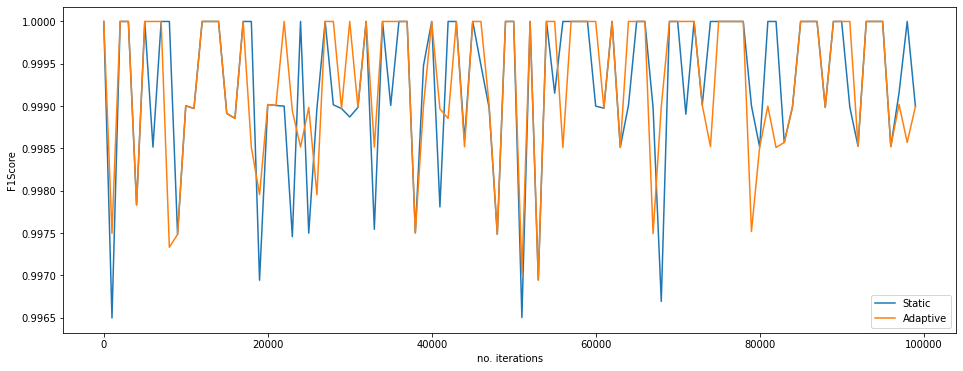

In [111]:
x_axis = np.arange(0,100000,1000)
x_axis.shape
figure(figsize=(16, 6))
plt.plot(x_axis, f1_1000Chunk_list_static_multi, label='Static')
plt.plot(x_axis, f1_1000Chunk_list_adaptive_multi, label='Adaptive')
plt.xlabel('no. iterations')
plt.ylabel('F1Score')
plt.legend()
plt.show()

##### Overall Average F1-Score

In [113]:
print("Adaptive avg F1", sum(f1_1000Chunk_list_static_multi)/len(f1_1000Chunk_list_static_multi))
print("Static avg F1", sum(f1_1000Chunk_list_adaptive_multi)/len(f1_1000Chunk_list_adaptive_multi))

Adaptive avg F1 0.9992566864124397
Static avg F1 0.9992833179807576
